## EDA and Statistical test

In [1]:
#Importing packages
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from sklearn.decomposition import PCA
import scipy
from sklearn.datasets import load_boston
import plotly.express as px

In [2]:
# Importing datasets
gtrend = pd.read_csv("Search Words_clean.csv", index_col = "Date")
crypto = pd.read_csv("Crypto Close_clean.csv", index_col = "Date")


#training data
btc = pd.read_csv("BTC.csv", index_col = "Date")
bnb = pd.read_csv("BNB.csv", index_col = "Date")
ltc = pd.read_csv("LTC.csv", index_col = "Date")
bch = pd.read_csv("BCH.csv", index_col = "Date")
xmr = pd.read_csv("XMR.csv", index_col = "Date")
xrp = pd.read_csv("XRP.csv", index_col = "Date")

#test data
eth = pd.read_csv("ETH.csv", index_col = "Date")
link = pd.read_csv("LINK.csv", index_col = "Date")
doge = pd.read_csv("DOGE.csv", index_col = "Date")
ada = pd.read_csv("ADA.csv", index_col = "Date")

btc.rename(columns = {btc.columns[0]: "Return"}, inplace = True)
bnb.rename(columns = {bnb.columns[0]: "Return"}, inplace = True)
bch.rename(columns = {bch.columns[0]: "Return"}, inplace = True)
ltc.rename(columns = {ltc.columns[0]: "Return"}, inplace = True)
xmr.rename(columns = {xmr.columns[0]: "Return"}, inplace = True)
xrp.rename(columns = {xrp.columns[0]: "Return"}, inplace = True)

eth.rename(columns = {eth.columns[0]: "Return"}, inplace = True)
link.rename(columns = {link.columns[0]: "Return"}, inplace = True)
doge.rename(columns = {doge.columns[0]: "Return"}, inplace = True)
ada.rename(columns = {ada.columns[0]: "Return"}, inplace = True)

Text(0.5, 1.0, 'Bitcoin Prices')

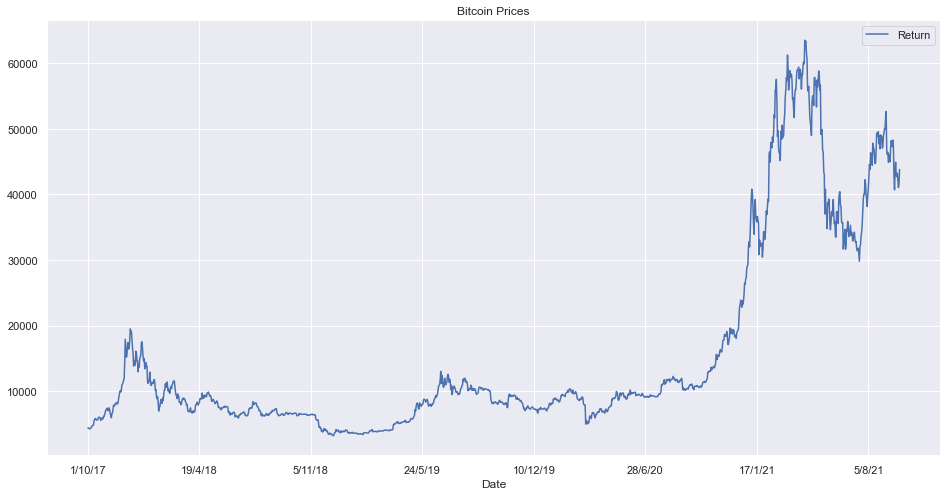

In [3]:
btc.plot(figsize=(16,8), label='price')
plt.legend()
plt.title("Bitcoin Prices")

Text(0.5, 1.0, 'Cryptocurrency')

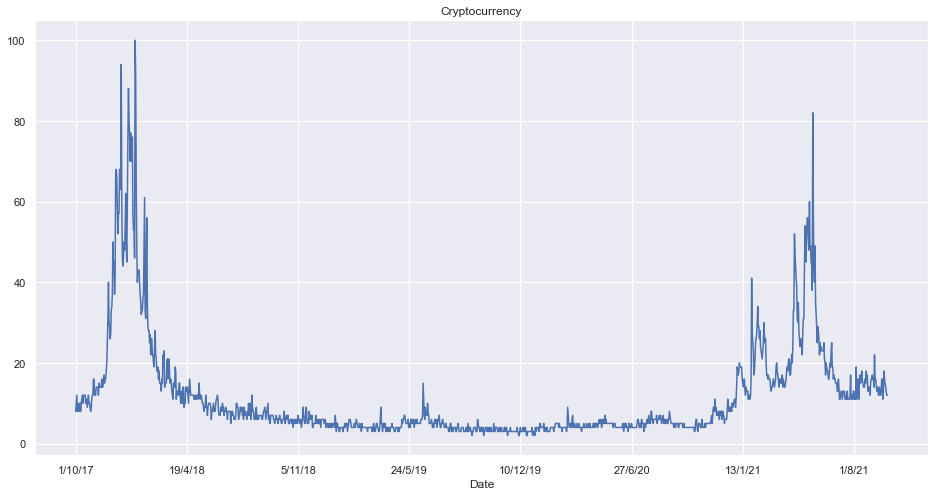

In [4]:
gtrend.Cryptocurrency.plot(figsize=(16,8))
plt.title("Cryptocurrency")

In [5]:
#Generating returns for dependent variable
btc_return = btc/btc.shift(1)-1
bnb_return = bnb/bnb.shift(1)-1
bch_return = bch/bch.shift(1)-1
ltc_return = ltc/ltc.shift(1)-1
xmr_return = xmr/xmr.shift(1)-1
xrp_return = xrp/xrp.shift(1)-1


gtrend_return = gtrend.diff()
training_set = pd.concat([btc_return, bnb_return, bch_return, ltc_return, xmr_return, xrp_return])

In [6]:
combine_dataset_1 = pd.merge(training_set, gtrend_return,left_on="Date", right_on="Date")
combine_dataset = combine_dataset_1.copy().dropna()

<AxesSubplot:xlabel='Date'>

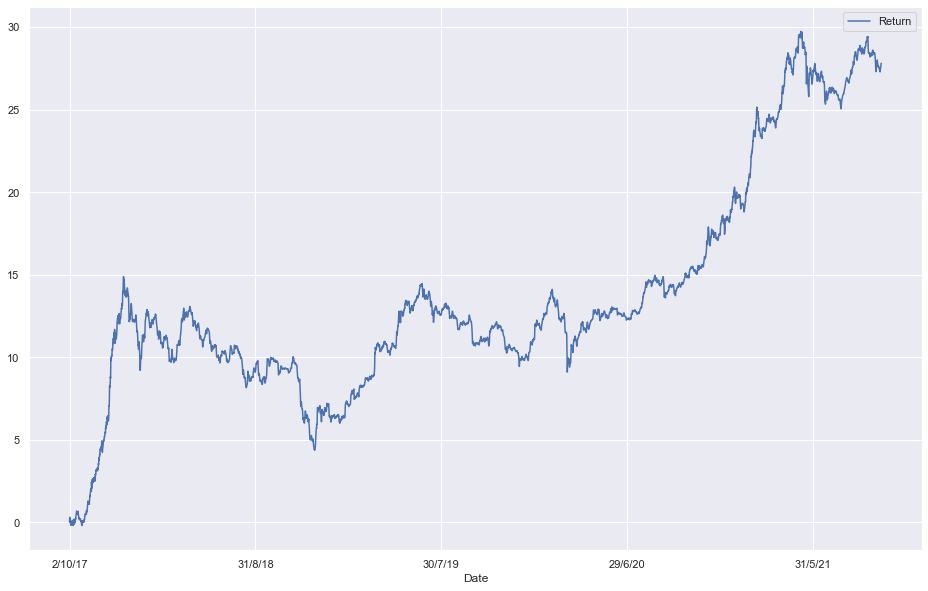

In [7]:
combine_dataset[["Return"]].dropna().cumsum().plot(figsize=(16,10))

In [8]:
y_split_1 = combine_dataset[["Return"]].loc[:"28/6/20"]
y_split_2 = combine_dataset[["Return"]].loc["29/6/20":]

x_split_1 = combine_dataset.loc[:"28/6/20"].drop("Return", axis = 1)
x_split_2 = combine_dataset.loc["29/6/20":].drop("Return", axis = 1)

In [9]:
featureslist_all = list(combine_dataset.columns)
featureslist_all.remove("Return")

In [10]:
model_dummy = sm.OLS(combine_dataset[["Return"]],combine_dataset[featureslist_all]).fit()
RSSd = model_dummy.ssr

model_b = sm.OLS(y_split_1, x_split_1).fit()
RSSb = model_b.ssr

model_nb = sm.OLS(y_split_2, x_split_2).fit()
RSSnb = model_nb.ssr

K = combine_dataset[featureslist_all].shape[1]
N1 = x_split_1.shape[0]
N2 = x_split_2.shape[0]

In [11]:
chow = ((RSSd - (RSSb + RSSnb))/K) / ((RSSb + RSSnb)/(N1 + N2 - 2*K))
scipy.stats.f.cdf(chow, K, N1 + N2 - 2*K)

0.9999999999999999

<AxesSubplot:title={'center':'Correlation Matrix'}>

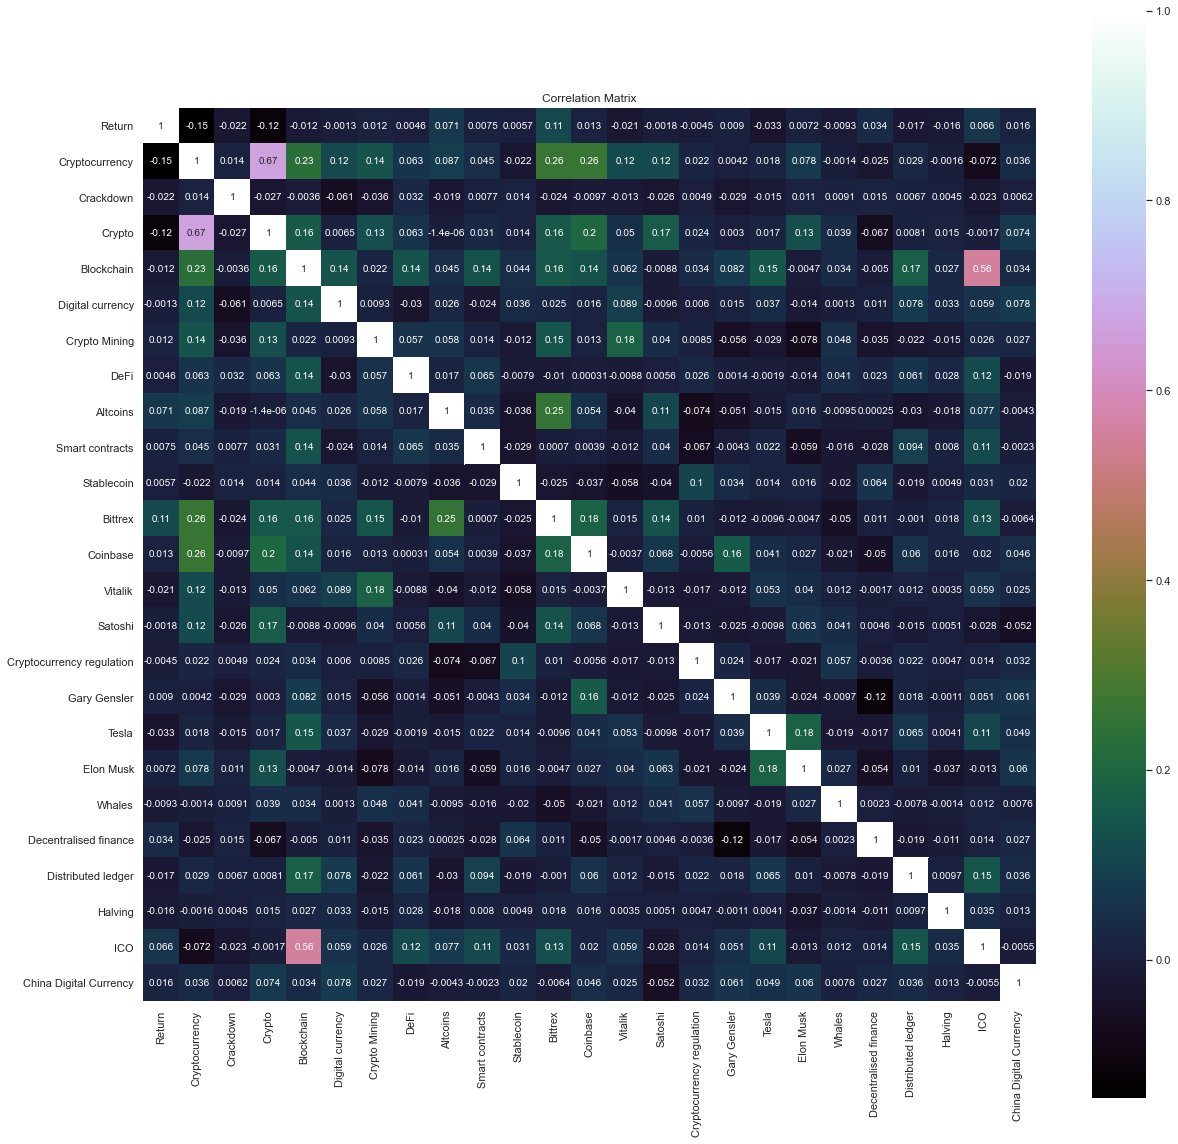

In [12]:
correlation = combine_dataset.corr()

plt.figure(figsize = (20, 20)
          )

plt.title("Correlation Matrix")

sns.heatmap(correlation,
            vmax = 1,
           square = True,
           annot = True,
           cmap = "cubehelix")

In [13]:
featureslist_all = list(combine_dataset.columns)
featureslist_all.remove("Return")

In [14]:
#Running PCA analysis
combine_dataset.dropna(subset=featureslist_all, inplace=True)
features = combine_dataset.loc[:, featureslist_all].values
from sklearn.preprocessing import StandardScaler
features = StandardScaler().fit_transform(features)
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
principal_components = pca.fit_transform(features)
principal_components
pca.explained_variance_ratio_

array([0.09717893, 0.07040979, 0.05683854, 0.05184766, 0.04988098,
       0.04894657, 0.04810452, 0.0444868 , 0.04244936, 0.04149325])

In [15]:
pca.explained_variance_ratio_.sum()

0.5516364113944873

In [16]:
pc_df = pd.DataFrame(principal_components)
#pc_df.corr()
pc_df.columns = ['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
pc_df.index = combine_dataset.index
data_merge = pd.concat([combine_dataset, pc_df], axis=1)

In [17]:
result = sm.OLS(data_merge['Return'], sm.add_constant(data_merge[['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']]), missing='drop').fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     33.29
Date:                Mon, 13 Jun 2022   Prob (F-statistic):           3.17e-64
Time:                        20:14:09   Log-Likelihood:                 12062.
No. Observations:                8736   AIC:                        -2.410e+04
Df Residuals:                    8725   BIC:                        -2.402e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      4.888      0.0

/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [18]:
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_white
wtest = het_white(result.resid, result.model.exog)
labels = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
lzip(labels, wtest)

[('Lagrange Multiplier statistic:', 348.3626682804197),
 ("LM test's p-value:", 2.320771145665327e-40),
 ('F-statistic:', 5.539846167075033),
 ("F-test's p-value:", 2.2058395029455066e-41)]

In [19]:
# Transform all to log

btc_lgreturn = np.log(btc).diff()
bnb_lgreturn = np.log(bnb).diff()
ltc_lgreturn = np.log(ltc).diff()
bch_lgreturn = np.log(bch).diff()
xmr_lgreturn = np.log(xmr).diff()
xrp_lgreturn = np.log(xrp).diff()

eth_return = np.log(eth).diff()
link_return = np.log(link).diff()
doge_return = np.log(doge).diff()
ada_return = np.log(ada).diff()

gtrend_return = gtrend.diff()
training_set_2 = pd.concat([btc_lgreturn, bnb_lgreturn, ltc_lgreturn, bch_lgreturn, xmr_lgreturn, xrp_lgreturn])
test_set = pd.concat([eth_return, link_return, doge_return, ada_return], axis = 1)

In [20]:
combine_dataset_2 = pd.merge(training_set_2, gtrend_return,left_on="Date", right_on="Date").dropna()

In [21]:
featureslist_all = list(combine_dataset_2.columns)
featureslist_all.remove("Return")

In [22]:
#Running PCA analysis
combine_dataset_2.dropna(subset=featureslist_all, inplace=True)
features = combine_dataset_2.loc[:, featureslist_all].values
from sklearn.preprocessing import StandardScaler
features = StandardScaler().fit_transform(features)
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
principal_components = pca.fit_transform(features)
principal_components
pca.explained_variance_ratio_
#array output is the explained variance for each pc

array([0.09717975, 0.07040866, 0.05682137, 0.05197286, 0.04986024,
       0.04889616, 0.04818809, 0.04437083, 0.04232084, 0.04149596])

In [23]:
pc_df = pd.DataFrame(principal_components)
#pc_df.corr()
pc_df.columns = ['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
pc_df.index = combine_dataset_2.index
data_merge_2 = pd.concat([combine_dataset_2, pc_df], axis=1)

In [24]:
result_2= sm.OLS(data_merge_2['Return'], sm.add_constant(data_merge_2[['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']]), missing='drop').fit()
print(result_2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     39.81
Date:                Mon, 13 Jun 2022   Prob (F-statistic):           1.66e-77
Time:                        20:14:10   Log-Likelihood:                 12276.
No. Observations:                8736   AIC:                        -2.453e+04
Df Residuals:                    8725   BIC:                        -2.445e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      2.085      0.0

/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [25]:
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_white
wtest = het_white(result_2.resid, result_2.model.exog)
labels = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
lzip(labels, wtest)

[('Lagrange Multiplier statistic:', 526.7504642694374),
 ("LM test's p-value:", 1.7983269185639746e-73),
 ('F-statistic:', 8.558688315471436),
 ("F-test's p-value:", 3.139311389799833e-76)]

In [26]:
from statsmodels.stats.diagnostic import linear_reset as lr
lr(result_2, power = 3)

/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:1263: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[196.37794563]], p-value=2.275468996977463e-43, df_denom=2>

In [27]:
square_terms = (gtrend_return.copy())**2
square_terms = square_terms.add_suffix("_sq")
cube_terms = (gtrend_return.copy())**3
cube_terms = cube_terms.add_suffix("_cb")

power_training = pd.concat([square_terms, cube_terms],axis = 1)
combine_dataset_2_power = pd.merge(combine_dataset_2, power_training,left_on="Date", right_on="Date").dropna()

In [28]:
featureslist_all = list(combine_dataset_2_power.columns)
featureslist_all.remove("Return")

In [29]:
combine_dataset_2_power.dropna(subset=featureslist_all, inplace=True)
features = combine_dataset_2_power.loc[:, featureslist_all].values
from sklearn.preprocessing import StandardScaler
features = StandardScaler().fit_transform(features)
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
principal_components = pca.fit_transform(features)
principal_components
pca.explained_variance_ratio_

array([0.05733492, 0.04535777, 0.04078552, 0.03625876, 0.03160789,
       0.03080231, 0.03045509, 0.02868444, 0.02798681, 0.02724736])

In [30]:
pc_df = pd.DataFrame(principal_components)
#pc_df.corr()
pc_df.columns = ['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
pc_df.index = combine_dataset_2_power.index
data_merge_2_power = pd.concat([combine_dataset_2_power, pc_df], axis=1)

In [31]:
result_2_power= sm.OLS(data_merge_2_power['Return'], sm.add_constant(data_merge_2_power[['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']]), missing='drop').fit()
print(result_2_power.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     57.10
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          1.70e-112
Time:                        20:14:10   Log-Likelihood:                 12358.
No. Observations:                8736   AIC:                        -2.469e+04
Df Residuals:                    8725   BIC:                        -2.462e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      2.105      0.0

/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [32]:
lr(result_2_power, power = 3)

/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:1263: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[21.83766121]], p-value=1.8113906402133055e-05, df_denom=2>

In [33]:
result_3= sm.OLS(data_merge_2_power['Return'], sm.add_constant(data_merge_2_power[['PC1', 'PC2', 'PC3', 'PC4', 'PC6','PC8']]), missing='drop').fit()
print(result_3.summary())

/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     94.10
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          5.68e-115
Time:                        20:14:10   Log-Likelihood:                 12355.
No. Observations:                8736   AIC:                        -2.470e+04
Df Residuals:                    8729   BIC:                        -2.465e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      2.104      0.0

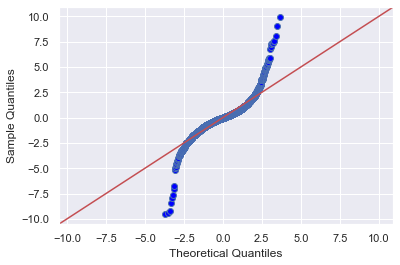

In [34]:
import statsmodels.api as sm
from matplotlib import pyplot as plt

res = result_3.resid # residuals
fig = sm.qqplot(res, fit=True, line="45")
plt.show()

## Time series to look for autocorrelation

In [35]:
# Test for stationarity
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(data_merge_2_power['Return'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -14.199523
p-value: 0.000000


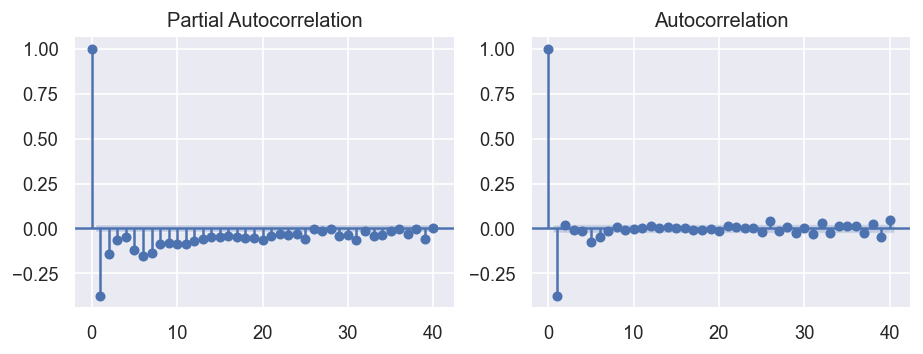

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
plot_pacf(data_merge_2_power['Return'].diff().dropna(), ax=axes[0])
plot_acf(data_merge_2_power['Return'].diff().dropna(), ax=axes[1])
plt.show()

In [37]:
from statsmodels.tsa.arima.model import ARIMA
model_arimax = ARIMA(data_merge_2_power['Return'], exog = data_merge_2_power[['PC1','PC2','PC3','PC4','PC6','PC8','PC9']], order = (1,0,1))
results_arimax = model_arimax.fit()
print(results_arimax.summary())

/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueW

                               SARIMAX Results                                
Dep. Variable:                 Return   No. Observations:                 8736
Model:                 ARIMA(1, 0, 1)   Log Likelihood               13708.147
Date:                Mon, 13 Jun 2022   AIC                         -27394.294
Time:                        20:14:22   BIC                         -27316.466
Sample:                             0   HQIC                        -27367.772
                               - 8736                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      0.946      0.344      -0.001       0.004
PC1           -0.0048      0.000    -25.885      0.000      -0.005      -0.004
PC2           -0.0031      0.000    -10.289      0.0

## Predictions

In [38]:
test_set.dropna(inplace=True)

In [39]:
predictions = result_3.predict()
predictions_2 = predictions[::6]
test_set['Predictions'] = predictions_2

In [40]:
predictions_arimax = results_arimax.predict()
predictions_3 = predictions_arimax[::6]
test_set['Predictions_ARIMAX'] = predictions_3

In [41]:
new_columns = ['ETH_RETURNS','LINK_RETURNS','DOGE_RETURNS','ADA_RETURNS','PREDICTIONS','PREDICTIONS_ARIMAX']

test_set.columns = new_columns

test_set.dropna(inplace = True)

In [42]:
from sklearn.metrics import mean_squared_error

mean_squared_error(test_set["ADA_RETURNS"], predictions_3)

0.006673413912788397

In [43]:
#plt.plot(test_set['PREDICTIONS'],'ro')

In [44]:
#plt.plot(test_set['PREDICTIONS_ARIMAX'],'bo')

In [45]:
test_set['PREDICTIONS'].describe(percentiles = [0.25, 0.5, 0.75])

count    1456.000000
mean        0.001325
std         0.014965
min        -0.325325
25%        -0.000441
50%         0.002145
75%         0.004189
max         0.080979
Name: PREDICTIONS, dtype: float64

In [46]:
percentile_25 = test_set['PREDICTIONS'].describe(percentiles = [0.25, 0.5, 0.75])[4]
percentile_75 = test_set['PREDICTIONS'].describe(percentiles = [0.25, 0.5, 0.75])[6]

def change_sign(x):
    if x < percentile_25:
        return 1
    elif x > percentile_75:
        return -1
    else:
        return 0

 0    728
-1    364
 1    364
Name: sign, dtype: int64

ETH_RETURNS    9.090525
STRATEGY       5.897849
Name: 30/9/21, dtype: float64

Sharpe Ratio: 1.0110282531436965
Total_returns: 5.8978487980995435
0.05309465050797668


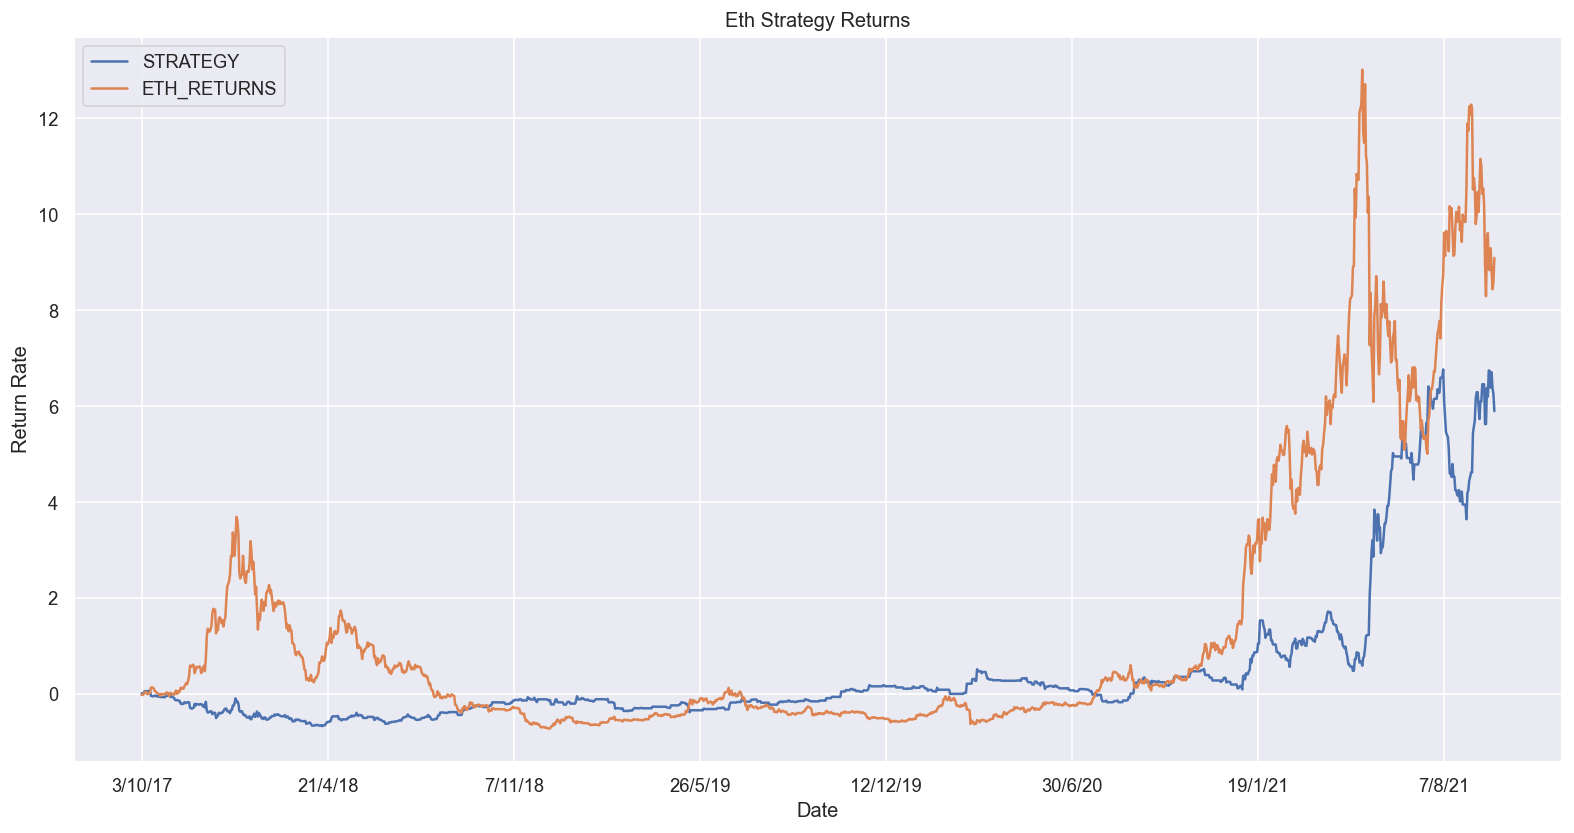

In [47]:

ETH_predict = pd.DataFrame(test_set['ETH_RETURNS'])
ADA_predict = pd.DataFrame(test_set['ADA_RETURNS'])
LINK_predict = pd.DataFrame(test_set['LINK_RETURNS'])
DOGE_predict = pd.DataFrame(test_set['DOGE_RETURNS'])

def plot_coin_return(coin_df,coin_return, test_set):

    coin_df['sign'] = test_set["PREDICTIONS"].apply(change_sign)

    #coin_df['volatility'] = gtrend['Crypto'].rolling(window = 30,min_periods = 1).std()
    
    display(coin_df['sign'].value_counts())

    coin_df["STRATEGY"] = coin_df["sign"].shift(1) * coin_df[coin_return]

    display((coin_df[[coin_return, "STRATEGY"]].dropna().cumsum().apply(np.exp)-1).iloc[-1])
    
    #(coin_df[[coin,"STRATEGY"]].dropna().cumsum().apply(np.exp)-1).plot(figsize=(16,8))
    (coin_df[["STRATEGY",coin_return]].dropna().cumsum().apply(np.exp)-1).plot(figsize=(16,8))
    #coin_df['volatility'].plot(secondary_y = 'volatility')

    daily_returns = coin_df['STRATEGY'].apply(np.exp)-1

    total_returns = coin_df[["STRATEGY"]].dropna().sum().apply(np.exp)-1
    
    Sharpe_ratio = np.sqrt(365) * (daily_returns.mean() / daily_returns.std())
    print(f'Sharpe Ratio: {Sharpe_ratio}')
    print(f'Total_returns: {total_returns[0]}')
    #print(f'long: {long_returns}')
    print(coin_df[coin_return].std())
    
    plt.title('Eth Strategy Returns')
    plt.ylabel('Return Rate')

plot_coin_return(ETH_predict,'ETH_RETURNS', test_set)

 0    728
-1    364
 1    364
Name: sign, dtype: int64

ADA_RETURNS    80.538330
STRATEGY        1.433471
Name: 30/9/21, dtype: float64

Sharpe Ratio: 0.7559923787373983
Total_returns: 1.4334713174870273
0.0736180296730435


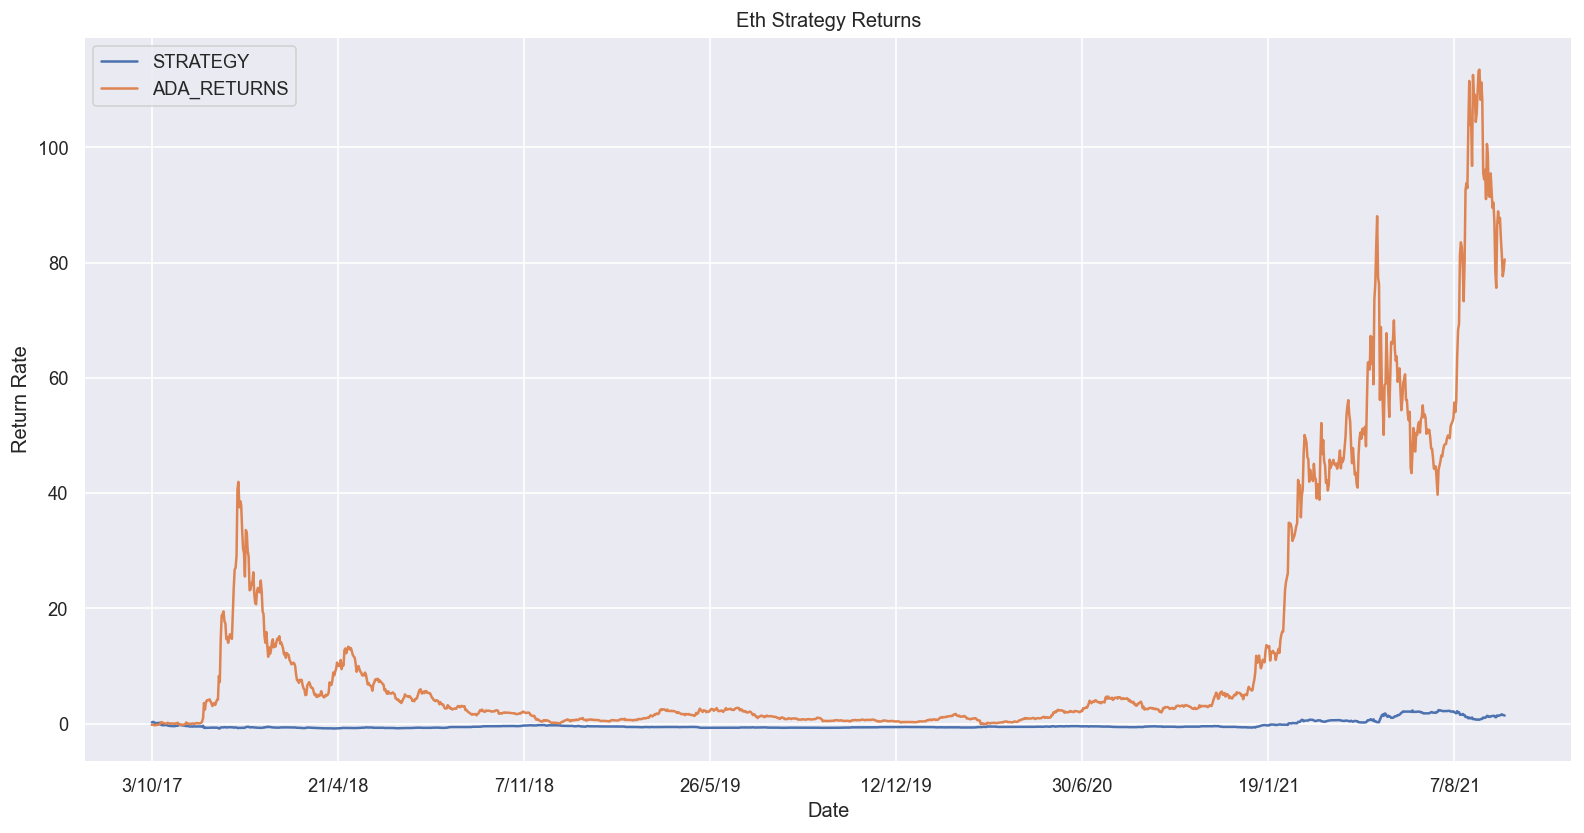

In [48]:
plot_coin_return(ADA_predict,'ADA_RETURNS', test_set)

 0    728
-1    364
 1    364
Name: sign, dtype: int64

DOGE_RETURNS    187.243321
STRATEGY          1.267854
Name: 30/9/21, dtype: float64

Sharpe Ratio: 0.7344085749197451
Total_returns: 1.2678543221392076
0.08243779185268076


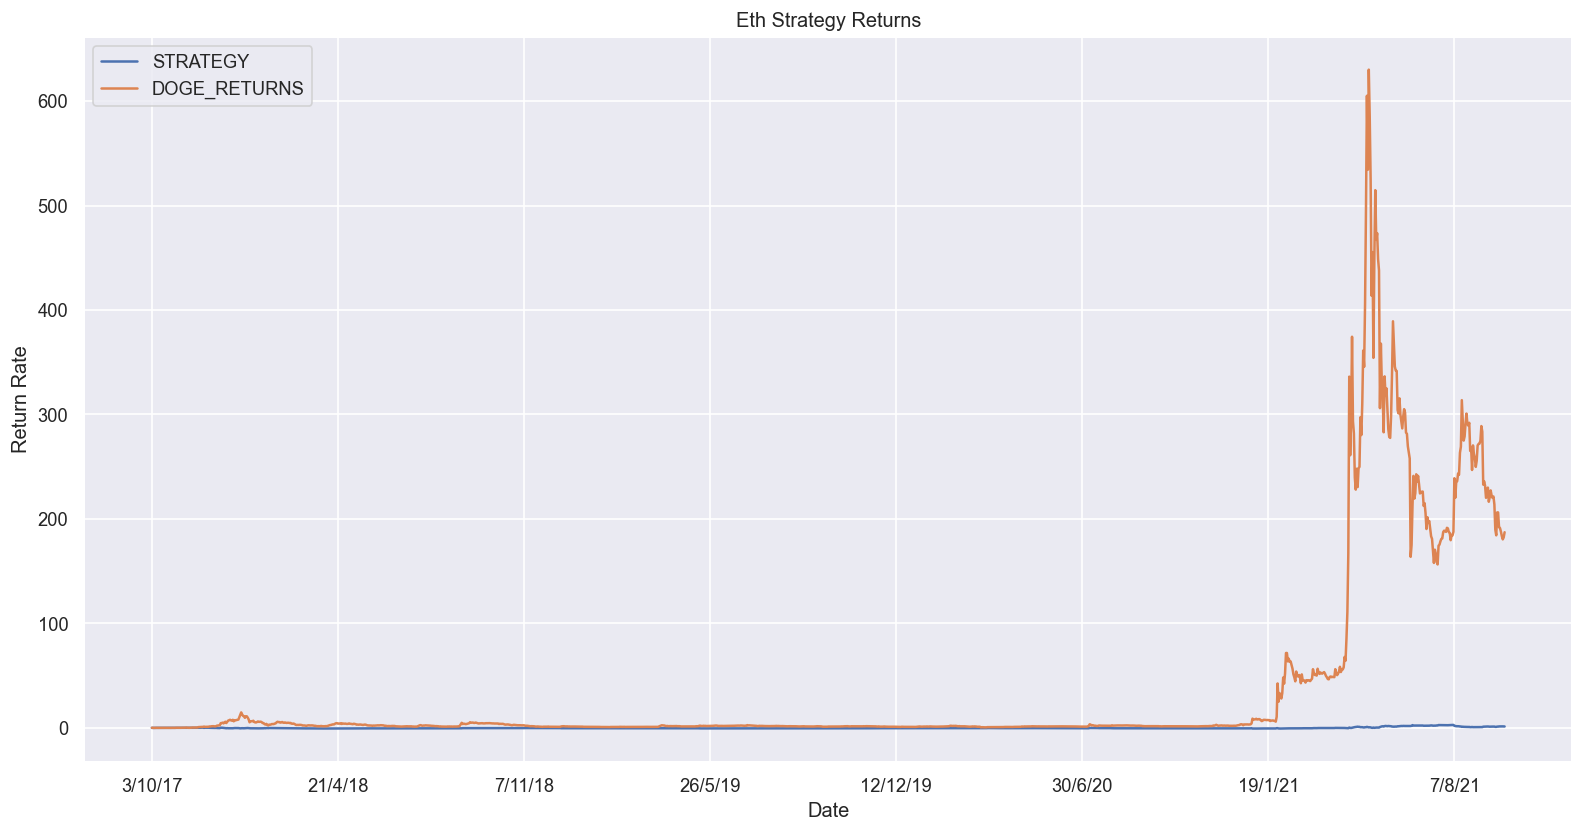

In [49]:
plot_coin_return(DOGE_predict,'DOGE_RETURNS', test_set)

 0    728
-1    364
 1    364
Name: sign, dtype: int64

LINK_RETURNS    66.232533
STRATEGY        12.219791
Name: 30/9/21, dtype: float64

Sharpe Ratio: 1.1171925414612711
Total_returns: 12.219790951447704
0.0768049416563285


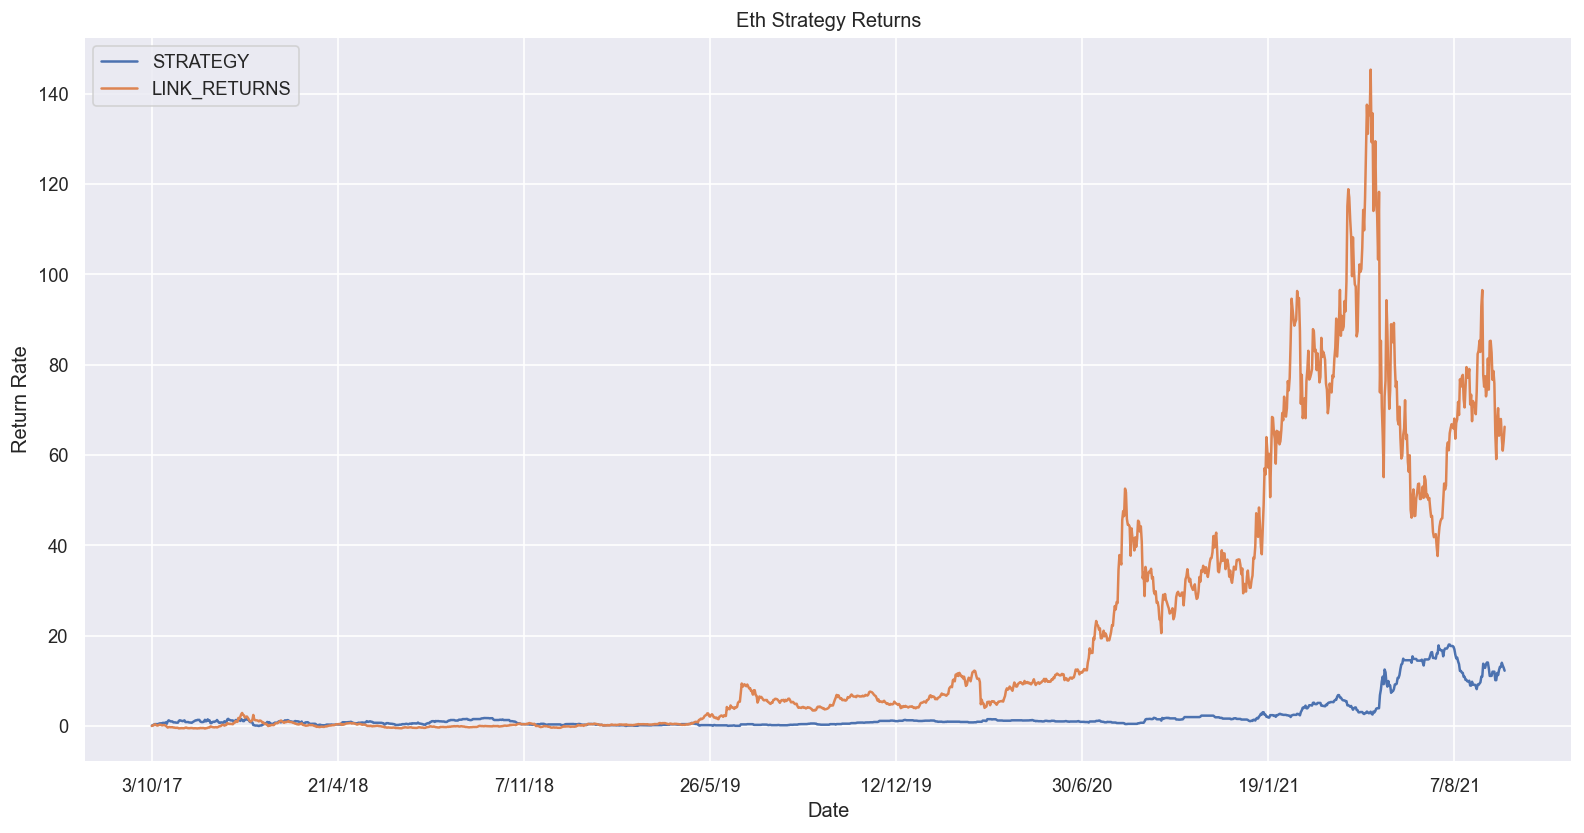

In [50]:
plot_coin_return(LINK_predict,'LINK_RETURNS', test_set)

,ETH_RETURNS,sign,STRATEGY
Date,,,
2/10/17,-0.016212,-1,NaN
3/10/17,-0.016992,1,0.016992
4/10/17,0.000666,0,0.000666
5/10/17,0.010892,1,0.000000
6/10/17,0.042111,0,0.042111
...,...,...,...
26/9/21,0.045667,-1,-0.045667
27/9/21,-0.042741,1,0.042741
28/9/21,-0.044192,-1,-0.044192


In [66]:
strategy = pd.concat([ETH_predict.STRATEGY, LINK_predict.STRATEGY, DOGE_predict.STRATEGY, ADA_predict.STRATEGY], axis=1)
strategy.columns = ["ETH","LINK","DOGE","ADA"]
strategy = strategy.loc["30/7/20":]
strategy.to_csv("Sentiment_Strategy.csv")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=789666f9-eecf-427a-9865-8e3ac8975b25' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>